In [8]:
# Install libraries
!pip install pytorch-tabnet ctgan optuna imbalanced-learn torch pandas numpy scikit-learn matplotlib seaborn

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from pytorch_tabnet.tab_model import TabNetClassifier
import optuna
from optuna import Trial
import torch
import torch.nn as nn
from ctgan import CTGAN
import pickle

# Set seeds
torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [9]:
# Load and preprocess
data = pd.read_csv('/content/fetal_health.csv')
features_to_drop = [
    'fetal_movement', 'histogram_width', 'histogram_max', 'mean_value_of_long_term_variability',
    'histogram_number_of_peaks', 'light_decelerations', 'histogram_tendency',
    'histogram_number_of_zeroes', 'severe_decelerations', 'baseline value', 'histogram_min'
]
data_dropped = data.drop(columns=features_to_drop)
data_dropped['fetal_health'] = data_dropped['fetal_health'].astype(int)
X = data_dropped.drop(['fetal_health'], axis=1)
y = data_dropped['fetal_health']

# Scale and simulate temporal data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
n_time_steps = 5
X_temporal = []
y_temporal = []
for i in range(len(X_scaled)):
    sample = X_scaled.iloc[i].values
    time_series = []
    for t in range(n_time_steps):
        noise = np.random.uniform(-0.05, 0.05, size=sample.shape)
        noisy_sample = np.clip(sample + noise, 0, 1)
        time_series.append(noisy_sample)
    X_temporal.append(time_series)
    y_temporal.append(y.iloc[i])
X_temporal = np.array(X_temporal)
y_temporal = np.array(y_temporal)

In [10]:
# Temporal CTGAN
minority_mask = np.isin(y_temporal, [2, 3])
X_minority_temporal = X_temporal[minority_mask]
y_minority_temporal = y_temporal[minority_mask]
X_minority_flat = X_minority_temporal.reshape(len(X_minority_temporal), -1)
feature_names = [f'f{t}_{col}' for t in range(n_time_steps) for col in X.columns]
data_minority_flat = pd.DataFrame(X_minority_flat, columns=feature_names)
data_minority_flat['fetal_health'] = y_minority_temporal
n_samples_adjusted = (len(data_minority_flat) // 10) * 10
data_minority_trimmed = data_minority_flat.iloc[:n_samples_adjusted]
suspect_data = data_minority_trimmed[data_minority_trimmed['fetal_health'] == 2]
pathological_data = data_minority_trimmed[data_minority_trimmed['fetal_health'] == 3]
ctgan_suspect = CTGAN(epochs=500, batch_size=50, verbose=True, cuda=True)
ctgan_suspect.fit(suspect_data, discrete_columns=['fetal_health'])
ctgan_pathological = CTGAN(epochs=500, batch_size=50, verbose=True, cuda=True)
ctgan_pathological.fit(pathological_data, discrete_columns=['fetal_health'])
n_suspect = 1655 - 295
n_pathological = 1655 - 176
synthetic_suspect = ctgan_suspect.sample(n_suspect)
synthetic_pathological = ctgan_pathological.sample(n_pathological)
synthetic_data = pd.concat([synthetic_suspect, synthetic_pathological], ignore_index=True)
synthetic_flat = synthetic_data.drop('fetal_health', axis=1).values
synthetic_labels = synthetic_data['fetal_health'].values
X_synthetic_temporal = synthetic_flat.reshape(-1, n_time_steps, X_scaled.shape[1])
X_gan_temporal = np.vstack([X_temporal, X_synthetic_temporal])
y_gan_temporal = np.hstack([y_temporal, synthetic_labels])

Gen. (-7.67) | Discrim. (2.85): 100%|██████████| 500/500 [03:02<00:00,  2.74it/s]
Gen. (-3.05) | Discrim. (0.66): 100%|██████████| 500/500 [01:43<00:00,  4.83it/s]


In [11]:
# Split and flatten
X_train, X_test, y_train, y_test = train_test_split(
    X_gan_temporal, y_gan_temporal, test_size=0.3, random_state=42, stratify=y_gan_temporal
)
X_train_final, X_valid, y_train_final, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)
X_train_flat = X_train_final.reshape(-1, n_time_steps * X_scaled.shape[1])
X_valid_flat = X_valid.reshape(-1, n_time_steps * X_scaled.shape[1])
X_test_flat = X_test.reshape(-1, n_time_steps * X_scaled.shape[1])

In [12]:
# Optuna tuning (keep your original function)
def objective(trial: Trial):
    n_d = trial.suggest_int('n_d', 32, 128)
    n_a = trial.suggest_int('n_a', 32, 128)
    n_steps = trial.suggest_int('n_steps', 3, 10)
    gamma = trial.suggest_float('gamma', 1.0, 2.0)
    lambda_sparse = trial.suggest_float('lambda_sparse', 1e-4, 1e-2, log=True)
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True)
    batch_size = trial.suggest_categorical('batch_size', [128, 256, 512])
    tabnet = UncertaintyTabNet(
        input_dim=n_time_steps * X_scaled.shape[1],
        output_dim=3,
        n_d=n_d, n_a=n_a, n_steps=n_steps, gamma=gamma,
        lambda_sparse=lambda_sparse, optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=learning_rate), mask_type='sparsemax', verbose=0
    )
    tabnet.fit(X_train_flat, y_train_final, eval_set=[(X_valid_flat, y_valid)], max_epochs=100, patience=20, batch_size=batch_size)
    y_pred = np.argmax(tabnet.predict_proba(X_valid_flat)[0], axis=1) + 1
    return accuracy_score(y_valid, y_pred)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2025-03-07 02:55:22,784] A new study created in memory with name: no-name-97dea92b-dc8d-4038-9312-42f4908fd035



Early stopping occurred at epoch 61 with best_epoch = 41 and best_val_0_accuracy = 0.96115


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
<ipython-input-7-0eb623f98781>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(self.device)
[I 2025-03-07 02:55:44,117] Trial 0 finished with value: 0.9194244604316547 and parameters: {'n_d': 124, 'n_a': 65, 'n_steps': 3, 'gamma': 1.9630249468244363, 'lambda_sparse': 0.0005042765167811175, 'learning_rate': 0.03010336640258786, 'batch_size': 256}. Best is trial 0 with value: 0.9194244604316547.



Early stopping occurred at epoch 81 with best_epoch = 61 and best_val_0_accuracy = 0.95683


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
<ipython-input-7-0eb623f98781>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(self.device)
[I 2025-03-07 02:57:50,038] Trial 1 finished with value: 0.9223021582733812 and parameters: {'n_d': 34, 'n_a': 63, 'n_steps': 10, 'gamma': 1.3340807236336336, 'lambda_sparse': 0.0017945006834948739, 'learning_rate': 0.013709541533710467, 'batch_size': 128}. Best is trial 1 with value: 0.9223021582733812.



Early stopping occurred at epoch 79 with best_epoch = 59 and best_val_0_accuracy = 0.95827


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
<ipython-input-7-0eb623f98781>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(self.device)
[I 2025-03-07 02:58:34,363] Trial 2 finished with value: 0.9194244604316547 and parameters: {'n_d': 90, 'n_a': 66, 'n_steps': 6, 'gamma': 1.5009343242709567, 'lambda_sparse': 0.004866672178797903, 'learning_rate': 0.0041001491118923825, 'batch_size': 256}. Best is trial 1 with value: 0.9223021582733812.


Stop training because you reached max_epochs = 100 with best_epoch = 82 and best_val_0_accuracy = 0.93957


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
<ipython-input-7-0eb623f98781>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(self.device)
[I 2025-03-07 02:59:25,291] Trial 3 finished with value: 0.8805755395683453 and parameters: {'n_d': 58, 'n_a': 115, 'n_steps': 9, 'gamma': 1.1453635547124041, 'lambda_sparse': 0.0003144356108325272, 'learning_rate': 0.0024939943818654627, 'batch_size': 512}. Best is trial 1 with value: 0.9223021582733812.



Early stopping occurred at epoch 81 with best_epoch = 61 and best_val_0_accuracy = 0.95827


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
<ipython-input-7-0eb623f98781>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(self.device)
[I 2025-03-07 03:00:16,609] Trial 4 finished with value: 0.9007194244604316 and parameters: {'n_d': 71, 'n_a': 68, 'n_steps': 7, 'gamma': 1.568216331210424, 'lambda_sparse': 0.0004244325810457374, 'learning_rate': 0.01719760456821651, 'batch_size': 256}. Best is trial 1 with value: 0.9223021582733812.


Stop training because you reached max_epochs = 100 with best_epoch = 95 and best_val_0_accuracy = 0.96403


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
<ipython-input-7-0eb623f98781>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(self.device)
[I 2025-03-07 03:01:27,281] Trial 5 finished with value: 0.9035971223021583 and parameters: {'n_d': 94, 'n_a': 111, 'n_steps': 8, 'gamma': 1.0137454041777603, 'lambda_sparse': 0.00016296782276411124, 'learning_rate': 0.0067964854080733005, 'batch_size': 256}. Best is trial 1 with value: 0.9223021582733812.



Early stopping occurred at epoch 86 with best_epoch = 66 and best_val_0_accuracy = 0.94964


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
<ipython-input-7-0eb623f98781>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(self.device)
[I 2025-03-07 03:02:36,379] Trial 6 finished with value: 0.9237410071942446 and parameters: {'n_d': 87, 'n_a': 72, 'n_steps': 9, 'gamma': 1.6944940725885331, 'lambda_sparse': 0.002578175420119197, 'learning_rate': 0.007582636874942687, 'batch_size': 256}. Best is trial 6 with value: 0.9237410071942446.



Early stopping occurred at epoch 67 with best_epoch = 47 and best_val_0_accuracy = 0.95827


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
<ipython-input-7-0eb623f98781>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(self.device)
[I 2025-03-07 03:03:14,380] Trial 7 finished with value: 0.9294964028776979 and parameters: {'n_d': 108, 'n_a': 126, 'n_steps': 6, 'gamma': 1.2980492007975326, 'lambda_sparse': 0.009777585109528013, 'learning_rate': 0.00708404067797675, 'batch_size': 256}. Best is trial 7 with value: 0.9294964028776979.


Stop training because you reached max_epochs = 100 with best_epoch = 87 and best_val_0_accuracy = 0.93094


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
<ipython-input-7-0eb623f98781>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(self.device)
[I 2025-03-07 03:03:50,158] Trial 8 finished with value: 0.8820143884892087 and parameters: {'n_d': 63, 'n_a': 88, 'n_steps': 6, 'gamma': 1.426833280512413, 'lambda_sparse': 0.00010912910343871081, 'learning_rate': 0.002438161936521401, 'batch_size': 512}. Best is trial 7 with value: 0.9294964028776979.



Early stopping occurred at epoch 65 with best_epoch = 45 and best_val_0_accuracy = 0.96259


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
<ipython-input-7-0eb623f98781>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(self.device)
[I 2025-03-07 03:04:32,260] Trial 9 finished with value: 0.9237410071942446 and parameters: {'n_d': 56, 'n_a': 107, 'n_steps': 7, 'gamma': 1.7094500814347806, 'lambda_sparse': 0.00017376086197339182, 'learning_rate': 0.08756631792557358, 'batch_size': 256}. Best is trial 7 with value: 0.9294964028776979.



Early stopping occurred at epoch 79 with best_epoch = 59 and best_val_0_accuracy = 0.96403


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
<ipython-input-7-0eb623f98781>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(self.device)
[I 2025-03-07 03:05:30,465] Trial 10 finished with value: 0.9093525179856116 and parameters: {'n_d': 124, 'n_a': 34, 'n_steps': 4, 'gamma': 1.2548361729417232, 'lambda_sparse': 0.008940664052242869, 'learning_rate': 0.0014033827160205381, 'batch_size': 128}. Best is trial 7 with value: 0.9294964028776979.



Early stopping occurred at epoch 84 with best_epoch = 64 and best_val_0_accuracy = 0.96259


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
<ipython-input-7-0eb623f98781>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(self.device)
[I 2025-03-07 03:06:11,360] Trial 11 finished with value: 0.9366906474820144 and parameters: {'n_d': 106, 'n_a': 94, 'n_steps': 5, 'gamma': 1.7973039867640046, 'lambda_sparse': 0.002030353387074685, 'learning_rate': 0.007161810317674455, 'batch_size': 256}. Best is trial 11 with value: 0.9366906474820144.



Early stopping occurred at epoch 41 with best_epoch = 21 and best_val_0_accuracy = 0.95252


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
<ipython-input-7-0eb623f98781>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(self.device)
[I 2025-03-07 03:06:31,759] Trial 12 finished with value: 0.935251798561151 and parameters: {'n_d': 108, 'n_a': 128, 'n_steps': 5, 'gamma': 1.9867027363006597, 'lambda_sparse': 0.0011528108536512044, 'learning_rate': 0.02963482593627118, 'batch_size': 256}. Best is trial 11 with value: 0.9366906474820144.



Early stopping occurred at epoch 48 with best_epoch = 28 and best_val_0_accuracy = 0.96259


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
<ipython-input-7-0eb623f98781>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(self.device)
[I 2025-03-07 03:07:07,538] Trial 13 finished with value: 0.9467625899280575 and parameters: {'n_d': 107, 'n_a': 91, 'n_steps': 4, 'gamma': 1.9862819354663797, 'lambda_sparse': 0.001075111739678473, 'learning_rate': 0.038645230585066505, 'batch_size': 128}. Best is trial 13 with value: 0.9467625899280575.



Early stopping occurred at epoch 48 with best_epoch = 28 and best_val_0_accuracy = 0.95683


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
<ipython-input-7-0eb623f98781>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(self.device)
[I 2025-03-07 03:07:36,844] Trial 14 finished with value: 0.9482014388489208 and parameters: {'n_d': 105, 'n_a': 91, 'n_steps': 3, 'gamma': 1.8138986388704432, 'lambda_sparse': 0.0008616669322260091, 'learning_rate': 0.09341153714462574, 'batch_size': 128}. Best is trial 14 with value: 0.9482014388489208.



Early stopping occurred at epoch 84 with best_epoch = 64 and best_val_0_accuracy = 0.96691


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
<ipython-input-7-0eb623f98781>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(self.device)
[I 2025-03-07 03:08:27,313] Trial 15 finished with value: 0.9453237410071943 and parameters: {'n_d': 102, 'n_a': 93, 'n_steps': 3, 'gamma': 1.8516741236058816, 'lambda_sparse': 0.0007533447218152833, 'learning_rate': 0.07697329653437242, 'batch_size': 128}. Best is trial 14 with value: 0.9482014388489208.



Early stopping occurred at epoch 44 with best_epoch = 24 and best_val_0_accuracy = 0.96403


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
<ipython-input-7-0eb623f98781>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(self.device)
[I 2025-03-07 03:09:00,413] Trial 16 finished with value: 0.9410071942446043 and parameters: {'n_d': 79, 'n_a': 49, 'n_steps': 4, 'gamma': 1.8628515588763475, 'lambda_sparse': 0.0010569293582312245, 'learning_rate': 0.045069782036480384, 'batch_size': 128}. Best is trial 14 with value: 0.9482014388489208.



Early stopping occurred at epoch 43 with best_epoch = 23 and best_val_0_accuracy = 0.96835


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
<ipython-input-7-0eb623f98781>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(self.device)
[I 2025-03-07 03:09:32,605] Trial 17 finished with value: 0.939568345323741 and parameters: {'n_d': 117, 'n_a': 82, 'n_steps': 4, 'gamma': 1.6666434969044166, 'lambda_sparse': 0.003698730941666416, 'learning_rate': 0.050755753554490475, 'batch_size': 128}. Best is trial 14 with value: 0.9482014388489208.



Early stopping occurred at epoch 50 with best_epoch = 30 and best_val_0_accuracy = 0.95396


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
<ipython-input-7-0eb623f98781>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(self.device)
[I 2025-03-07 03:10:02,910] Trial 18 finished with value: 0.9482014388489208 and parameters: {'n_d': 94, 'n_a': 101, 'n_steps': 3, 'gamma': 1.9125404466285452, 'lambda_sparse': 0.0006826603550649701, 'learning_rate': 0.09622567235748893, 'batch_size': 128}. Best is trial 14 with value: 0.9482014388489208.



Early stopping occurred at epoch 39 with best_epoch = 19 and best_val_0_accuracy = 0.95827


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
<ipython-input-7-0eb623f98781>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(self.device)
[I 2025-03-07 03:10:26,720] Trial 19 finished with value: 0.9496402877697842 and parameters: {'n_d': 80, 'n_a': 103, 'n_steps': 3, 'gamma': 1.7754600590221106, 'lambda_sparse': 0.0006762710167411346, 'learning_rate': 0.09740040556227401, 'batch_size': 128}. Best is trial 19 with value: 0.9496402877697842.


Stop training because you reached max_epochs = 100 with best_epoch = 94 and best_val_0_accuracy = 0.96978


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
<ipython-input-7-0eb623f98781>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(self.device)
[I 2025-03-07 03:10:57,104] Trial 20 finished with value: 0.9366906474820144 and parameters: {'n_d': 41, 'n_a': 117, 'n_steps': 5, 'gamma': 1.5960184809868543, 'lambda_sparse': 0.00025727963765251235, 'learning_rate': 0.02038540215131327, 'batch_size': 512}. Best is trial 19 with value: 0.9496402877697842.



Early stopping occurred at epoch 57 with best_epoch = 37 and best_val_0_accuracy = 0.96547


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
<ipython-input-7-0eb623f98781>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(self.device)
[I 2025-03-07 03:11:32,068] Trial 21 finished with value: 0.9424460431654677 and parameters: {'n_d': 74, 'n_a': 104, 'n_steps': 3, 'gamma': 1.7918873206139336, 'lambda_sparse': 0.0006492375782753446, 'learning_rate': 0.09910573553256893, 'batch_size': 128}. Best is trial 19 with value: 0.9496402877697842.



Early stopping occurred at epoch 51 with best_epoch = 31 and best_val_0_accuracy = 0.96259


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
<ipython-input-7-0eb623f98781>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(self.device)
[I 2025-03-07 03:12:02,943] Trial 22 finished with value: 0.9482014388489208 and parameters: {'n_d': 96, 'n_a': 96, 'n_steps': 3, 'gamma': 1.864595894994061, 'lambda_sparse': 0.0007144841056334167, 'learning_rate': 0.06611033406612978, 'batch_size': 128}. Best is trial 19 with value: 0.9496402877697842.



Early stopping occurred at epoch 46 with best_epoch = 26 and best_val_0_accuracy = 0.96835


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
<ipython-input-7-0eb623f98781>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(self.device)
[I 2025-03-07 03:12:30,730] Trial 23 finished with value: 0.9366906474820144 and parameters: {'n_d': 84, 'n_a': 103, 'n_steps': 3, 'gamma': 1.7722346971150233, 'lambda_sparse': 0.0015795157043735429, 'learning_rate': 0.06049415317917969, 'batch_size': 128}. Best is trial 19 with value: 0.9496402877697842.



Early stopping occurred at epoch 41 with best_epoch = 21 and best_val_0_accuracy = 0.95971


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
<ipython-input-7-0eb623f98781>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(self.device)
[I 2025-03-07 03:13:02,501] Trial 24 finished with value: 0.9280575539568345 and parameters: {'n_d': 97, 'n_a': 80, 'n_steps': 4, 'gamma': 1.9122799165984983, 'lambda_sparse': 0.0003816428073926918, 'learning_rate': 0.03198700015603835, 'batch_size': 128}. Best is trial 19 with value: 0.9496402877697842.



Early stopping occurred at epoch 66 with best_epoch = 46 and best_val_0_accuracy = 0.96403


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
<ipython-input-7-0eb623f98781>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(self.device)
[I 2025-03-07 03:13:41,791] Trial 25 finished with value: 0.9410071942446043 and parameters: {'n_d': 115, 'n_a': 100, 'n_steps': 3, 'gamma': 1.7178499350107472, 'lambda_sparse': 0.0006338813217619956, 'learning_rate': 0.0924840851988296, 'batch_size': 128}. Best is trial 19 with value: 0.9496402877697842.



Early stopping occurred at epoch 86 with best_epoch = 66 and best_val_0_accuracy = 0.96547


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
<ipython-input-7-0eb623f98781>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(self.device)
[I 2025-03-07 03:14:57,836] Trial 26 finished with value: 0.939568345323741 and parameters: {'n_d': 78, 'n_a': 83, 'n_steps': 5, 'gamma': 1.579413121409532, 'lambda_sparse': 0.00024584563083297165, 'learning_rate': 0.05458518310573015, 'batch_size': 128}. Best is trial 19 with value: 0.9496402877697842.



Early stopping occurred at epoch 57 with best_epoch = 37 and best_val_0_accuracy = 0.96547


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
<ipython-input-7-0eb623f98781>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(self.device)
[I 2025-03-07 03:15:40,927] Trial 27 finished with value: 0.943884892086331 and parameters: {'n_d': 68, 'n_a': 119, 'n_steps': 4, 'gamma': 1.8888943459463756, 'lambda_sparse': 0.0013970854114794648, 'learning_rate': 0.021385532410360054, 'batch_size': 128}. Best is trial 19 with value: 0.9496402877697842.


Stop training because you reached max_epochs = 100 with best_epoch = 88 and best_val_0_accuracy = 0.96259


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
<ipython-input-7-0eb623f98781>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(self.device)
[I 2025-03-07 03:16:01,443] Trial 28 finished with value: 0.9424460431654677 and parameters: {'n_d': 85, 'n_a': 75, 'n_steps': 3, 'gamma': 1.791463159540924, 'lambda_sparse': 0.000517795511565343, 'learning_rate': 0.0676505819135273, 'batch_size': 512}. Best is trial 19 with value: 0.9496402877697842.



Early stopping occurred at epoch 54 with best_epoch = 34 and best_val_0_accuracy = 0.96403


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
<ipython-input-7-0eb623f98781>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(self.device)
[I 2025-03-07 03:16:34,187] Trial 29 finished with value: 0.9381294964028777 and parameters: {'n_d': 126, 'n_a': 58, 'n_steps': 3, 'gamma': 1.6591612055778722, 'lambda_sparse': 0.0009041450025732648, 'learning_rate': 0.02961645233930599, 'batch_size': 128}. Best is trial 19 with value: 0.9496402877697842.



Early stopping occurred at epoch 45 with best_epoch = 25 and best_val_0_accuracy = 0.96403


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
<ipython-input-7-0eb623f98781>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(self.device)
[I 2025-03-07 03:17:15,131] Trial 30 finished with value: 0.9338129496402877 and parameters: {'n_d': 101, 'n_a': 111, 'n_steps': 5, 'gamma': 1.9277841394180741, 'lambda_sparse': 0.00047305907518084035, 'learning_rate': 0.039953287116600664, 'batch_size': 128}. Best is trial 19 with value: 0.9496402877697842.



Early stopping occurred at epoch 51 with best_epoch = 31 and best_val_0_accuracy = 0.96835


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
<ipython-input-7-0eb623f98781>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(self.device)
[I 2025-03-07 03:17:46,846] Trial 31 finished with value: 0.9381294964028777 and parameters: {'n_d': 92, 'n_a': 98, 'n_steps': 3, 'gamma': 1.8437447306692927, 'lambda_sparse': 0.0007796897713502987, 'learning_rate': 0.06864566353248276, 'batch_size': 128}. Best is trial 19 with value: 0.9496402877697842.



Early stopping occurred at epoch 72 with best_epoch = 52 and best_val_0_accuracy = 0.9554


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
<ipython-input-7-0eb623f98781>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(self.device)
[I 2025-03-07 03:18:40,142] Trial 32 finished with value: 0.9309352517985612 and parameters: {'n_d': 98, 'n_a': 87, 'n_steps': 4, 'gamma': 1.9304438355088847, 'lambda_sparse': 0.0005567259895269818, 'learning_rate': 0.07664375590197794, 'batch_size': 128}. Best is trial 19 with value: 0.9496402877697842.



Early stopping occurred at epoch 35 with best_epoch = 15 and best_val_0_accuracy = 0.95396


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
<ipython-input-7-0eb623f98781>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(self.device)
[I 2025-03-07 03:19:01,833] Trial 33 finished with value: 0.9424460431654677 and parameters: {'n_d': 116, 'n_a': 98, 'n_steps': 3, 'gamma': 1.7581713219369053, 'lambda_sparse': 0.0008208804589228011, 'learning_rate': 0.09814937457238325, 'batch_size': 128}. Best is trial 19 with value: 0.9496402877697842.



Early stopping occurred at epoch 73 with best_epoch = 53 and best_val_0_accuracy = 0.96547


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
<ipython-input-7-0eb623f98781>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(self.device)
[I 2025-03-07 03:19:45,789] Trial 34 finished with value: 0.9424460431654677 and parameters: {'n_d': 93, 'n_a': 96, 'n_steps': 3, 'gamma': 1.8649562428272706, 'lambda_sparse': 0.002002201861093394, 'learning_rate': 0.055356344866363844, 'batch_size': 128}. Best is trial 19 with value: 0.9496402877697842.



Early stopping occurred at epoch 57 with best_epoch = 37 and best_val_0_accuracy = 0.96403


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
<ipython-input-7-0eb623f98781>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(self.device)
[I 2025-03-07 03:21:20,368] Trial 35 finished with value: 0.9453237410071943 and parameters: {'n_d': 88, 'n_a': 107, 'n_steps': 10, 'gamma': 1.9969403508000727, 'lambda_sparse': 0.0003713830501678633, 'learning_rate': 0.013258456224676517, 'batch_size': 128}. Best is trial 19 with value: 0.9496402877697842.


Stop training because you reached max_epochs = 100 with best_epoch = 95 and best_val_0_accuracy = 0.96259


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
<ipython-input-7-0eb623f98781>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(self.device)
[I 2025-03-07 03:21:46,636] Trial 36 finished with value: 0.9424460431654677 and parameters: {'n_d': 81, 'n_a': 111, 'n_steps': 4, 'gamma': 1.5040092580795539, 'lambda_sparse': 0.0012422088100647907, 'learning_rate': 0.06578456384097821, 'batch_size': 512}. Best is trial 19 with value: 0.9496402877697842.



Early stopping occurred at epoch 61 with best_epoch = 41 and best_val_0_accuracy = 0.95971


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
<ipython-input-7-0eb623f98781>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(self.device)
[I 2025-03-07 03:23:08,059] Trial 37 finished with value: 0.9323741007194245 and parameters: {'n_d': 112, 'n_a': 122, 'n_steps': 8, 'gamma': 1.8111269156969307, 'lambda_sparse': 0.0028458799949591905, 'learning_rate': 0.03852231130594281, 'batch_size': 128}. Best is trial 19 with value: 0.9496402877697842.



Early stopping occurred at epoch 87 with best_epoch = 67 and best_val_0_accuracy = 0.96978


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
<ipython-input-7-0eb623f98781>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(self.device)
[I 2025-03-07 03:23:59,699] Trial 38 finished with value: 0.920863309352518 and parameters: {'n_d': 49, 'n_a': 75, 'n_steps': 3, 'gamma': 1.424840378727949, 'lambda_sparse': 0.00031284036442492437, 'learning_rate': 0.004741755881836303, 'batch_size': 128}. Best is trial 19 with value: 0.9496402877697842.



Early stopping occurred at epoch 64 with best_epoch = 44 and best_val_0_accuracy = 0.96835


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
<ipython-input-7-0eb623f98781>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(self.device)
[I 2025-03-07 03:24:47,033] Trial 39 finished with value: 0.9223021582733812 and parameters: {'n_d': 100, 'n_a': 88, 'n_steps': 4, 'gamma': 1.7446030502514458, 'lambda_sparse': 0.0006726159347336368, 'learning_rate': 0.010692174635868445, 'batch_size': 128}. Best is trial 19 with value: 0.9496402877697842.



Early stopping occurred at epoch 95 with best_epoch = 75 and best_val_0_accuracy = 0.96115


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
<ipython-input-7-0eb623f98781>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(self.device)
[I 2025-03-07 03:25:21,480] Trial 40 finished with value: 0.9410071942446043 and parameters: {'n_d': 75, 'n_a': 102, 'n_steps': 6, 'gamma': 1.6306799406719226, 'lambda_sparse': 0.00158145263343359, 'learning_rate': 0.07808096997022873, 'batch_size': 512}. Best is trial 19 with value: 0.9496402877697842.



Early stopping occurred at epoch 35 with best_epoch = 15 and best_val_0_accuracy = 0.95683


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
<ipython-input-7-0eb623f98781>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(self.device)
[I 2025-03-07 03:25:42,644] Trial 41 finished with value: 0.9323741007194245 and parameters: {'n_d': 107, 'n_a': 91, 'n_steps': 3, 'gamma': 1.9538970680936867, 'lambda_sparse': 0.0009840080910412097, 'learning_rate': 0.048373306293195834, 'batch_size': 128}. Best is trial 19 with value: 0.9496402877697842.



Early stopping occurred at epoch 57 with best_epoch = 37 and best_val_0_accuracy = 0.95683


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
<ipython-input-7-0eb623f98781>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(self.device)
[I 2025-03-07 03:26:25,269] Trial 42 finished with value: 0.9496402877697842 and parameters: {'n_d': 95, 'n_a': 90, 'n_steps': 4, 'gamma': 1.9472937088578544, 'lambda_sparse': 0.0010069482985211105, 'learning_rate': 0.0379532181924021, 'batch_size': 128}. Best is trial 19 with value: 0.9496402877697842.



Early stopping occurred at epoch 57 with best_epoch = 37 and best_val_0_accuracy = 0.96403


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
<ipython-input-7-0eb623f98781>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(self.device)
[I 2025-03-07 03:27:00,116] Trial 43 finished with value: 0.9568345323741008 and parameters: {'n_d': 90, 'n_a': 86, 'n_steps': 3, 'gamma': 1.9080694902662798, 'lambda_sparse': 0.0005477009039361701, 'learning_rate': 0.09931532317631023, 'batch_size': 128}. Best is trial 43 with value: 0.9568345323741008.



Early stopping occurred at epoch 49 with best_epoch = 29 and best_val_0_accuracy = 0.95683


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
<ipython-input-7-0eb623f98781>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(self.device)
[I 2025-03-07 03:27:37,024] Trial 44 finished with value: 0.9309352517985612 and parameters: {'n_d': 89, 'n_a': 85, 'n_steps': 4, 'gamma': 1.9347238590796434, 'lambda_sparse': 0.00047616556348112593, 'learning_rate': 0.09921483477612107, 'batch_size': 128}. Best is trial 43 with value: 0.9568345323741008.



Early stopping occurred at epoch 43 with best_epoch = 23 and best_val_0_accuracy = 0.95971


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
<ipython-input-7-0eb623f98781>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(self.device)
[I 2025-03-07 03:28:28,537] Trial 45 finished with value: 0.9453237410071943 and parameters: {'n_d': 66, 'n_a': 79, 'n_steps': 7, 'gamma': 1.8260391346367566, 'lambda_sparse': 0.0005775307145482362, 'learning_rate': 0.08222297723625399, 'batch_size': 128}. Best is trial 43 with value: 0.9568345323741008.



Early stopping occurred at epoch 84 with best_epoch = 64 and best_val_0_accuracy = 0.96547


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
<ipython-input-7-0eb623f98781>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(self.device)
[I 2025-03-07 03:28:55,847] Trial 46 finished with value: 0.9280575539568345 and parameters: {'n_d': 84, 'n_a': 67, 'n_steps': 3, 'gamma': 1.0570234112781778, 'lambda_sparse': 0.00031043460807718984, 'learning_rate': 0.025842869597522355, 'batch_size': 256}. Best is trial 43 with value: 0.9568345323741008.



Early stopping occurred at epoch 41 with best_epoch = 21 and best_val_0_accuracy = 0.95827


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
<ipython-input-7-0eb623f98781>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(self.device)
[I 2025-03-07 03:29:33,235] Trial 47 finished with value: 0.935251798561151 and parameters: {'n_d': 103, 'n_a': 112, 'n_steps': 5, 'gamma': 1.8974662442248775, 'lambda_sparse': 0.000922112878217201, 'learning_rate': 0.04571178006854396, 'batch_size': 128}. Best is trial 43 with value: 0.9568345323741008.



Early stopping occurred at epoch 81 with best_epoch = 61 and best_val_0_accuracy = 0.95971


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
<ipython-input-7-0eb623f98781>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(self.device)
[I 2025-03-07 03:31:30,837] Trial 48 finished with value: 0.9424460431654677 and parameters: {'n_d': 121, 'n_a': 106, 'n_steps': 9, 'gamma': 1.9719731125333773, 'lambda_sparse': 0.001285098987230846, 'learning_rate': 0.08029628578529649, 'batch_size': 128}. Best is trial 43 with value: 0.9568345323741008.



Early stopping occurred at epoch 82 with best_epoch = 62 and best_val_0_accuracy = 0.95827


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
<ipython-input-7-0eb623f98781>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(self.device)
[I 2025-03-07 03:32:04,146] Trial 49 finished with value: 0.9035971223021583 and parameters: {'n_d': 94, 'n_a': 61, 'n_steps': 4, 'gamma': 1.7149074499650465, 'lambda_sparse': 0.00019380709621412556, 'learning_rate': 0.0013717896244188701, 'batch_size': 256}. Best is trial 43 with value: 0.9568345323741008.


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.29399 | valid_accuracy: 0.66475 |  0:00:03s
epoch 1  | loss: 0.47326 | valid_accuracy: 0.60288 |  0:00:04s
epoch 2  | loss: 0.36569 | valid_accuracy: 0.87626 |  0:00:05s
epoch 3  | loss: 0.38026 | valid_accuracy: 0.82878 |  0:00:06s
epoch 4  | loss: 0.36027 | valid_accuracy: 0.82734 |  0:00:07s
epoch 5  | loss: 0.36852 | valid_accuracy: 0.92806 |  0:00:07s
epoch 6  | loss: 0.33633 | valid_accuracy: 0.93094 |  0:00:08s
epoch 7  | loss: 0.34548 | valid_accuracy: 0.88777 |  0:00:08s
epoch 8  | loss: 0.34305 | valid_accuracy: 0.87338 |  0:00:09s
epoch 9  | loss: 0.30961 | valid_accuracy: 0.91942 |  0:00:09s
epoch 10 | loss: 0.30153 | valid_accuracy: 0.91511 |  0:00:10s
epoch 11 | loss: 0.32439 | valid_accuracy: 0.93525 |  0:00:10s
epoch 12 | loss: 0.31323 | valid_accuracy: 0.9295  |  0:00:11s
epoch 13 | loss: 0.28025 | valid_accuracy: 0.92518 |  0:00:11s
epoch 14 | loss: 0.29375 | valid_accuracy: 0.92086 |  0:00:12s
epoch 15 | loss: 0.2721  | valid_accuracy: 0.94532 |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
<ipython-input-14-3f657da0463c>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).to(self.device)



Temporal Uncertainty-Aware TabNet Classification Report:
              precision    recall  f1-score   support

      Normal       0.95      0.93      0.94       496
     Suspect       0.91      0.97      0.94       497
Pathological       1.00      0.96      0.98       497

    accuracy                           0.95      1490
   macro avg       0.95      0.95      0.95      1490
weighted avg       0.95      0.95      0.95      1490

Mean uncertainty: 0.2533


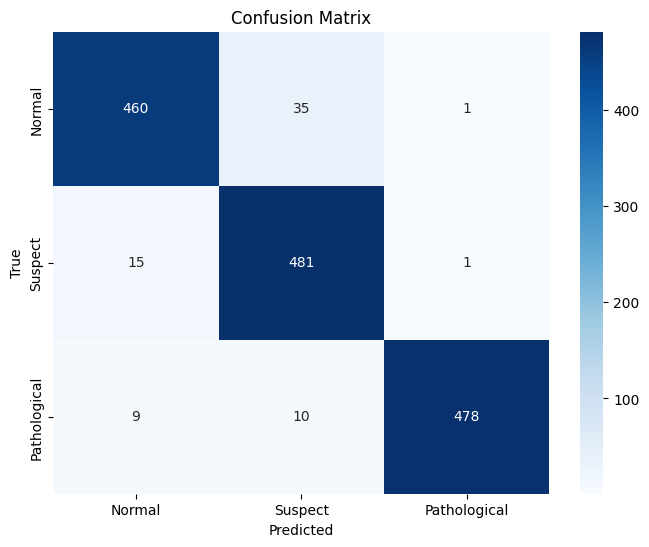

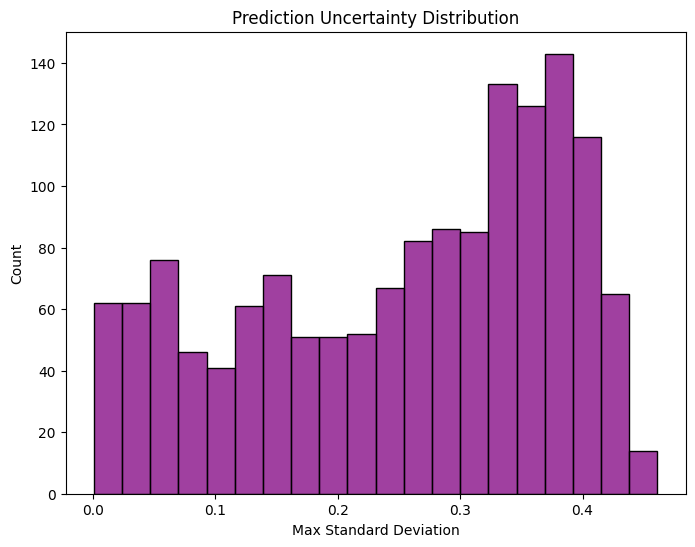

In [14]:
import numpy as np
import torch
import torch.nn as nn
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming device, study.best_params, X_train_flat, y_train_final, X_valid_flat, y_valid, X_test_flat, y_test are defined earlier
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the augment_data function (from your original ModelAttentionMask.py)
def augment_data(X, y, permutation_prob=0.1):
    """
    Augment the dataset by randomly permuting feature orders with a given probability.

    Parameters:
    - X (numpy.ndarray): Feature matrix (e.g., shape (samples, 50) for 5 time steps × 10 features).
    - y (numpy.ndarray): Target vector.
    - permutation_prob (float): Probability of permuting each sample.

    Returns:
    - X_augmented (numpy.ndarray): Augmented feature matrix.
    - y_augmented (numpy.ndarray): Augmented target vector.
    """
    X_augmented = []
    y_augmented = []
    for sample, label in zip(X, y):
        if np.random.rand() < permutation_prob:
            perm = np.random.permutation(sample.shape[0])  # Permute the 50 features
            sample = sample[perm]
        X_augmented.append(sample)
        y_augmented.append(label)
    return np.array(X_augmented), np.array(y_augmented)

# Define UncertaintyTabNet
class UncertaintyTabNet(TabNetClassifier):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.dropout = nn.Dropout(p=0.3).to(device)
        self.training = True
        self.device = device

    def forward(self, x):
        x = torch.tensor(x, dtype=torch.float32).to(self.device)
        if self.training or self.dropout.training:
            x = self.dropout(x)
        return self.network(x)

    def predict_proba(self, X):
        self.network.eval()
        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
            probs = []
            for _ in range(50):
                self.network.train()
                logits, _ = self.forward(X_tensor)
                prob = torch.softmax(logits, dim=1).cpu().numpy()
                probs.append(prob)
            probs = np.stack(probs, axis=0)
        return np.mean(probs, axis=0), np.std(probs, axis=0)

# Train with best params (assuming study.best_params is from your Optuna tuning)
perm_reg_tabnet = UncertaintyTabNet(
    input_dim=n_time_steps * X_scaled.shape[1],  # e.g., 50 (5 time steps × 10 features)
    output_dim=3,
    n_d=study.best_params['n_d'],
    n_a=study.best_params['n_a'],
    n_steps=study.best_params['n_steps'],
    gamma=study.best_params['gamma'],
    lambda_sparse=study.best_params['lambda_sparse'],
    optimizer_fn=torch.optim.Adam,
    optimizer_params={'lr': study.best_params['learning_rate']},
    mask_type='sparsemax',
    verbose=1,
    seed=42
)

# Apply data augmentation
X_train_augmented, y_train_augmented = augment_data(X_train_flat, y_train_final, permutation_prob=0.1)

# Train the model
perm_reg_tabnet.fit(
    X_train=X_train_augmented,
    y_train=y_train_augmented,
    eval_set=[(X_valid_flat, y_valid)],
    eval_name=['valid'],
    eval_metric=['accuracy'],
    max_epochs=100,
    patience=20,
    batch_size=study.best_params['batch_size'],
    virtual_batch_size=128
)

# Evaluate
probs_mean, probs_std = perm_reg_tabnet.predict_proba(X_test_flat)
y_pred_mean = np.argmax(probs_mean, axis=1) + 1  # Adjust back to 1, 2, 3
y_pred_uncertainty = np.max(probs_std, axis=1)

print("\nTemporal Uncertainty-Aware TabNet Classification Report:")
print(classification_report(y_test, y_pred_mean, target_names=['Normal', 'Suspect', 'Pathological']))
print(f"Mean uncertainty: {np.mean(y_pred_uncertainty):.4f}")

# Confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_mean), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Suspect', 'Pathological'],
            yticklabels=['Normal', 'Suspect', 'Pathological'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Uncertainty distribution
plt.figure(figsize=(8, 6))
sns.histplot(y_pred_uncertainty, bins=20, color='purple')
plt.title('Prediction Uncertainty Distribution')
plt.xlabel('Max Standard Deviation')
plt.show()